# Getting started exercise for RSA3.0

## Introduction

In these three exercises you will get an introduction to the functionality of the new pyRSA-toolbox for inferring the underlying model representation based on measured data. Generally we assume that there is a true underlying representation, which is captured by our model. The measurement process like fMRI will lead to a distorted view of that representation, which we may or may not include into our analysis as an explicit measurement model.  

For illustration these exercises use simulated RDMs from the paper "Inferring brain-computational mechanisms with models of activity measurements" by Kriegeskorte & Diedrichsen (2016). Ground truth RDMs are here simulated based on the layers of Alexnet--the deep neural network model, which sparked the interest in deep learning. Simulated data rdms were generated as follows: First, voxel responses were generated by randomly selecting locations within the layer and modelling their response as a local average of the feature values. Then, noise was added to those voxel responses and RDMs were computed from these noisy responses. As model predictions to compare to, we use noise-free RDMs generated for each layer, by applying different amounts of smoothing and averaging to the layer representation. 

Our overall aim in this setting is to infer which representation the data rdms were based on, i.e. which layer was used for generating the data. Towards this aim we will make three steps:

In *Exercise 1*, we will load the data, convert them into the formats used in the toolbox and have a first exploratory look at the data.

In *Exercise 2*, we will compare the RDMs based on the undistorted representations to the simulated data RDMs. This is the classical and simplest approach and already allows us to perform model comparisons and the general evaluation of model-RDMs. This approach uses *fixed models*, i.e. each model predicts a single fixed RDM. We will see that this does not allow us to correctly infer the underlying representation though, because the measurement process distorts the RDMs too much.

In *Exercise 3*, we will apply *flexible models*. This means that each model predicts a distribution of RDMs. In the present context this means that the model is flexible in which measurement model is applied to explain the data. To evaluate such flexible models additional cross-validation is necessary, which we also discuss in this exercise.

## Exercise 1: Data and RDM handling

In [1]:
import numpy as np
from scipy import io
import matplotlib.pyplot as plt
import pyrsa

/Users/DoerLBH/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/Users/DoerLBH/opt/anaconda3/envs/mlenv/lib/python3.7/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/Users/DoerLBH/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/pywt/_utils.py:6: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Iterable


### Load model RDMs
Here the models are different layers of Alexnet.
For each layer, different models of how the fMRI voxels sample the neurons are being considered.

The simulated data were generated in Matlab (Kriegeskorte & Diedrichsen 2016). Thus, we load the Matlab files in .mat format.

For each model-RDM, we obtain the RDM itself, a model name, and a measurement model name. The model name specifies the layer used to generate the RDM. The measurement model name specifies the applied distortions.

In [34]:
from allensdk.core.brain_observatory_cache import BrainObservatoryCache
import pandas as pd
import h5py

boc = BrainObservatoryCache()


In [57]:
visual_areas = ['VISal', 'VISam', 'VISl', 'VISp', 'VISpm', 'VISrl']
cre_line = 'Cux2-CreERT2'
exps = boc.get_experiment_containers(targeted_structures=visual_areas, cre_lines=[cre_line])
data_set = pd.DataFrame(exps)

ses_set = []
ses_rdm = []
for i,exp_id in enumerate(data_set['id']):
    print(i,exp_id)
    exp_obj_info = pd.DataFrame(boc.get_ophys_experiments(experiment_container_ids=[exp_id]))
    exp_ses_id = boc.get_ophys_experiments(experiment_container_ids=[exp_id], stimuli=['natural_scenes'])[0]['id']
    ses_obj = boc.get_ophys_experiment_data(ophys_experiment_id=exp_ses_id)    
    ns = boc.get_ophys_experiment_analysis(ophys_experiment_id=exp_ses_id, stimulus_type='natural_scenes')
    ses_set.append(ses_obj)
    ses_rdm.append(ns.representational_similarity)


0 511510994


2020-08-27 05:30:22,926 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/516243940
2020-08-27 05:34:54,000 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/517010949
/Users/DoerLBH/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/Users/DoerLBH/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/Users/DoerLBH/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecation

1 511510867


2020-08-27 05:41:48,597 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/516243715
2020-08-27 05:47:45,140 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/517092467
/Users/DoerLBH/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/Users/DoerLBH/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/Users/DoerLBH/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecation

2 645413757


2020-08-27 05:58:44,744 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/645883993
2020-08-27 06:05:57,112 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/662333065
/Users/DoerLBH/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/Users/DoerLBH/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/Users/DoerLBH/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecation

3 592349242


2020-08-27 06:20:49,893 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/593518609
2020-08-27 06:26:19,520 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/599584879
/Users/DoerLBH/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/Users/DoerLBH/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/Users/DoerLBH/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecation

4 511510998


2020-08-27 06:36:11,192 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/516243736
2020-08-27 06:40:31,940 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/517024348
/Users/DoerLBH/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/Users/DoerLBH/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/Users/DoerLBH/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecation

5 659767480


2020-08-27 06:46:44,611 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/660075449
2020-08-27 06:52:46,602 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/680100396
/Users/DoerLBH/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/Users/DoerLBH/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/Users/DoerLBH/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecation

6 511510650


2020-08-27 07:02:50,831 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/514376818
2020-08-27 07:09:05,397 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/514840057
/Users/DoerLBH/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/Users/DoerLBH/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/Users/DoerLBH/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecation

7 699155263


2020-08-27 07:20:40,837 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/699857779
2020-08-27 07:25:51,194 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/731825013
/Users/DoerLBH/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/Users/DoerLBH/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/Users/DoerLBH/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecation

8 569645688


2020-08-27 07:34:35,770 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/569891342
2020-08-27 07:40:12,311 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/583176257
/Users/DoerLBH/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/Users/DoerLBH/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/Users/DoerLBH/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecation

9 660510591


2020-08-27 07:49:38,223 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/661424944
2020-08-27 07:54:04,863 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/673424941
/Users/DoerLBH/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/Users/DoerLBH/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/Users/DoerLBH/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecation

10 511510664


2020-08-27 08:00:55,229 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/514798760
2020-08-27 08:07:06,695 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/517039138
/Users/DoerLBH/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/Users/DoerLBH/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/Users/DoerLBH/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecation

11 710469197


2020-08-27 08:18:31,548 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/710959190
2020-08-27 08:22:49,837 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/731737034
/Users/DoerLBH/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/Users/DoerLBH/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/Users/DoerLBH/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecation

12 511510870


2020-08-27 08:29:19,149 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/516445696
2020-08-27 08:38:15,903 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/516606833
/Users/DoerLBH/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/Users/DoerLBH/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/Users/DoerLBH/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecation

13 712178509


2020-08-27 08:57:14,152 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/712942511
2020-08-27 09:03:23,104 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/732041234
/Users/DoerLBH/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/Users/DoerLBH/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/Users/DoerLBH/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecation

14 511510822


2020-08-27 09:14:38,531 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/516247313
2020-08-27 09:19:56,971 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/516601577
/Users/DoerLBH/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/Users/DoerLBH/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/Users/DoerLBH/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecation

15 556899621


2020-08-27 09:28:54,961 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/557509351
2020-08-27 09:32:26,315 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/562690181
/Users/DoerLBH/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/Users/DoerLBH/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/Users/DoerLBH/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecation

16 511510640


2020-08-27 09:36:38,348 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/514681679
2020-08-27 09:43:04,976 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/517034851
/Users/DoerLBH/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/Users/DoerLBH/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/Users/DoerLBH/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecation

17 565216521


2020-08-27 09:55:34,349 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/569415083
2020-08-27 10:01:36,725 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/583175240
/Users/DoerLBH/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/Users/DoerLBH/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/Users/DoerLBH/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecation

18 511510779


2020-08-27 10:12:10,438 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/516803372
2020-08-27 10:23:38,367 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/517103907
/Users/DoerLBH/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/Users/DoerLBH/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/Users/DoerLBH/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecation

19 566759225


2020-08-27 10:51:19,535 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/569955226
2020-08-27 10:56:42,038 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/583173469
/Users/DoerLBH/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/Users/DoerLBH/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/Users/DoerLBH/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecation

20 511510797


2020-08-27 11:05:41,738 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/514549621
2020-08-27 11:11:54,335 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/517091735
/Users/DoerLBH/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/Users/DoerLBH/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/Users/DoerLBH/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecation

21 511510836


2020-08-27 11:23:29,946 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/516238768
2020-08-27 11:31:08,943 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/516605039
/Users/DoerLBH/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/Users/DoerLBH/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/Users/DoerLBH/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecation

22 571541563


2020-08-27 11:46:26,014 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/572503089
2020-08-27 11:50:40,912 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/583177144
/Users/DoerLBH/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/Users/DoerLBH/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/Users/DoerLBH/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecation

23 511510667


2020-08-27 11:57:32,755 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/514422179
2020-08-27 12:04:54,518 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/517094717
/Users/DoerLBH/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/Users/DoerLBH/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/Users/DoerLBH/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecation

24 529487170


2020-08-27 12:20:08,545 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/530476977
2020-08-27 12:25:59,906 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/569718937
/Users/DoerLBH/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/Users/DoerLBH/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/Users/DoerLBH/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecation

25 511510848


2020-08-27 12:36:17,637 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/517032431
2020-08-27 12:46:11,456 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/517065194
/Users/DoerLBH/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/Users/DoerLBH/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/Users/DoerLBH/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecation

26 701048110


2020-08-27 13:08:25,100 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/707459036
2020-08-27 13:11:32,755 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/739187685
/Users/DoerLBH/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/Users/DoerLBH/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/Users/DoerLBH/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecation

27 652094915


2020-08-27 13:14:53,462 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/652784309
2020-08-27 13:18:14,163 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/662938989
/Users/DoerLBH/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/Users/DoerLBH/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/Users/DoerLBH/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecation

28 569287964


2020-08-27 13:21:45,811 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/570072232
2020-08-27 13:24:14,311 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/576408599
/Users/DoerLBH/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/Users/DoerLBH/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/Users/DoerLBH/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecation

29 524691282


2020-08-27 13:25:38,408 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/526515309
2020-08-27 13:34:02,959 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/529032453
/Users/DoerLBH/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/Users/DoerLBH/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/Users/DoerLBH/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecation

30 511510893


2020-08-27 13:52:14,697 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/516244121
2020-08-27 13:57:07,892 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/517086942
/Users/DoerLBH/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/Users/DoerLBH/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/Users/DoerLBH/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecation

31 511510670


2020-08-27 14:05:59,868 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/514684659
2020-08-27 14:15:50,992 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/517054097
/Users/DoerLBH/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/Users/DoerLBH/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/Users/DoerLBH/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecation

32 698260530


2020-08-27 14:38:28,748 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/699170141
2020-08-27 14:41:10,620 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/731640954
/Users/DoerLBH/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/Users/DoerLBH/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/Users/DoerLBH/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecation

33 566307034


2020-08-27 14:43:15,671 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/569955234
2020-08-27 14:49:20,293 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/583175311
/Users/DoerLBH/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/Users/DoerLBH/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/Users/DoerLBH/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecation

34 511510945


2020-08-27 15:00:38,228 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/516968110
2020-08-27 15:08:59,723 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/517055716
/Users/DoerLBH/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/Users/DoerLBH/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/Users/DoerLBH/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecation

35 570994450


2020-08-27 15:25:53,306 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/571177249
2020-08-27 15:30:42,659 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/583177567
/Users/DoerLBH/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/Users/DoerLBH/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/Users/DoerLBH/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecation

36 708949511


2020-08-27 15:38:25,020 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/710015320
2020-08-27 15:41:08,813 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/731625522
/Users/DoerLBH/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/Users/DoerLBH/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/Users/DoerLBH/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecation

37 511510695


2020-08-27 15:43:33,208 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/514383985
2020-08-27 15:47:50,963 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/515076216
/Users/DoerLBH/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/Users/DoerLBH/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/Users/DoerLBH/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecation

38 511511083


2020-08-27 15:53:59,964 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/514403115
2020-08-27 15:58:26,214 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/515076236
/Users/DoerLBH/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/Users/DoerLBH/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/Users/DoerLBH/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecation

39 511976252


2020-08-27 16:05:25,605 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/516251370
2020-08-27 16:08:53,220 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/517084939
/Users/DoerLBH/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/Users/DoerLBH/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/Users/DoerLBH/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecation

40 511511052


2020-08-27 16:12:58,330 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/516251550
2020-08-27 16:19:20,360 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/517045544
/Users/DoerLBH/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/Users/DoerLBH/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/Users/DoerLBH/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecation

41 647595663


2020-08-27 16:31:30,410 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/649334201
2020-08-27 16:36:21,032 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/662320096
/Users/DoerLBH/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/Users/DoerLBH/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/Users/DoerLBH/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecation

42 511510917


2020-08-27 16:44:17,404 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/516804280
2020-08-27 16:50:51,200 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/517047774
/Users/DoerLBH/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/Users/DoerLBH/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/Users/DoerLBH/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecation

43 551657958


2020-08-27 17:03:23,196 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/552520251
2020-08-27 17:07:20,413 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/566416785
/Users/DoerLBH/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/Users/DoerLBH/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/Users/DoerLBH/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecation

44 662351162


2020-08-27 17:12:31,046 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/662995297
2020-08-27 17:16:46,206 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/673397265
/Users/DoerLBH/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/Users/DoerLBH/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/Users/DoerLBH/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecation

45 555700037


2020-08-27 17:23:08,629 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/557934565
2020-08-27 17:27:24,156 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/559117096
/Users/DoerLBH/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/Users/DoerLBH/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/Users/DoerLBH/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecation

46 570008442


2020-08-27 17:32:51,294 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/570236077
2020-08-27 17:40:35,447 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/583178142
/Users/DoerLBH/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/Users/DoerLBH/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/Users/DoerLBH/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecation

47 556936291


2020-08-27 17:55:55,693 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/557957516
2020-08-27 18:02:55,761 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/559118667
/Users/DoerLBH/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/Users/DoerLBH/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/Users/DoerLBH/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecation

48 658534530


2020-08-27 18:15:16,997 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/664435651
2020-08-27 18:19:51,312 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/680046105
/Users/DoerLBH/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/Users/DoerLBH/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/Users/DoerLBH/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecation

49 511856567


2020-08-27 18:27:04,102 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/516346761
2020-08-27 18:34:13,697 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/516604151
/Users/DoerLBH/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/Users/DoerLBH/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/Users/DoerLBH/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecation

50 701412138


2020-08-27 18:48:15,690 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/704855394
2020-08-27 18:53:22,054 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/739202148
/Users/DoerLBH/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/Users/DoerLBH/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/Users/DoerLBH/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecation

51 614561352


2020-08-27 19:02:07,120 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/617208034
2020-08-27 19:05:18,518 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/662308122
/Users/DoerLBH/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/Users/DoerLBH/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/Users/DoerLBH/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecation

52 511510718


2020-08-27 19:08:48,022 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/516470788
2020-08-27 19:20:39,581 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/517034484
/Users/DoerLBH/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/Users/DoerLBH/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/Users/DoerLBH/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecation

53 591392164


2020-08-27 19:46:36,508 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/592661898
2020-08-27 19:50:12,405 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/599575992
/Users/DoerLBH/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/Users/DoerLBH/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/Users/DoerLBH/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecation

In [58]:
n_models = len(ses_set)
model_names = [ses_set[i].get_metadata()['targeted_structure'] for i in range(n_models)]
measurement_model = [ses_set[i].get_metadata()['imaging_depth_um'] for i in range(n_models)]
rdms_array = np.array([ses_rdm[i] for i in range(n_models)])

In [59]:
rdms_array.shape

(54, 119, 119)

These steps are not specific to the toolbox, but to the format the RDMs were originally saved in.
To load other data, simply transform them such that they are numpy arrays of either the whole RDM or vector format of the upper triangular part of the matrix.

### Store the model RDMs as a pyRSA object
We place the RDMs in a pyRSA object which can contain additional descriptors for the RDMs and the experimental conditions.
Here we label each RDM with the name of the brain-computational model (AlexNet layer) and the name of the measurement model.

In [60]:
model_rdms = pyrsa.rdm.RDMs(rdms_array,
                            rdm_descriptors={'brain_computational_model':model_names,
                                             'measurement_model':measurement_model},
                            dissimilarity_measure='Euclidean'
                           )

In [61]:
model_rdms.dissimilarities.shape

(54, 7021)

#### The variable model_rdms is now a custom object, which contains all the RDMs from the .mat file with the additional information.
It also has a few methods for forming subsets of the data, saving and loading, etc.

### Show the RDMs from AlexNet layer conv1

As a simple example, select the RDMs that correspond to the first convolutional layer. These can then be plotted using the function pyrsa.vis.show_rdm.

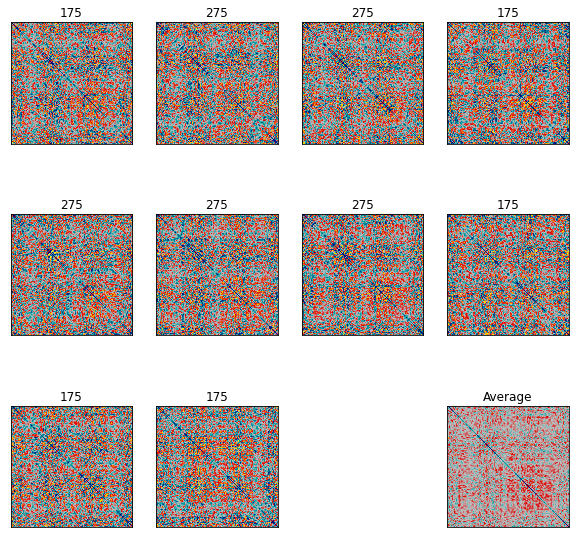

In [62]:
conv1_rdms = model_rdms.subset('brain_computational_model','VISl')
plt.figure(figsize=(10,10))
pyrsa.vis.show_rdm(conv1_rdms, do_rank_transform=True, rdm_descriptor='measurement_model')

These are the RDMs which were generated from convolutional layer 1 by different measurement models. Each RDM is labeled with the name of the measurement model. Also in the lower right corner the average RDM is plotted.

### Print information about a set of RDMs
The pyRSA objects can simply be passed to the print function to obtain a short description of their content.

In [63]:
conv1_rdms = model_rdms.subset('brain_computational_model','VISl')
print(conv1_rdms)

pyrsa.rdm.RDMs
10 RDM(s) over 119 conditions

dissimilarity_measure = 
Euclidean

dissimilarities[0] = 
[[ 0.          0.23343228 -0.00040816 ... -0.10999382 -0.01647495
  -0.09977737]
 [ 0.23343228  0.         -0.02280767 ...  0.08865801  0.32084106
  -0.01124304]
 [-0.00040816 -0.02280767  0.         ...  0.11694496 -0.06753247
  -0.01339518]
 ...
 [-0.10999382  0.08865801  0.11694496 ...  0.          0.06242424
   0.08592455]
 [-0.01647495  0.32084106 -0.06753247 ...  0.06242424  0.
  -0.0083859 ]
 [-0.09977737 -0.01124304 -0.01339518 ...  0.08592455 -0.0083859
   0.        ]]

descriptors: 

rdm_descriptors: 
brain_computational_model = ['VISl' 'VISl' 'VISl' 'VISl' 'VISl' 'VISl' 'VISl' 'VISl' 'VISl' 'VISl']
measurement_model = [175 275 275 175 275 275 275 175 175 175]
index = [ 0  7 12 16 24 25 34 41 42 43]

pattern_descriptors: 
index = [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35


### Questions

Of course, you can also show all RDMs or select any other subset. Have a look at the different RDMs!

How many RDMs are there for each layer?

Generate a plot which shows all RDMs with the 'complete' measurement model.

How different do the different measurement models look to you and how different do the different layers look?


## Exercise 2: Fixed model inference
### Load data RDMs
Here we use simulated data to demonstrate RSA inference.
Since we know the true data-generating model in each case, we can tell when inference fails or succeeds.

For each data RDM, we obtain the name of the underlying Layer, a full width at half maximum (FWHM) value and a noise standard deviation. The FWHM value specifies the spatial range the simulated voxels average over. The noise standard deviation specifies how much noise was added to the voxel responses.

In [6]:
matlab_data = io.matlab.loadmat('rdms_inferring/noisyModelRDMs_A2020.mat')
repr_names_matlab = matlab_data['reprNames']
fwhms_matlab = matlab_data['FWHMs']
noise_std_matlab = matlab_data['relNoiseStds']
rdms_matlab = matlab_data['noisyModelRDMs']
repr_names = [repr_names_matlab[i][0][0] for i in range(repr_names_matlab.shape[0])]
fwhms = fwhms_matlab.squeeze().astype('float')
noise_std = noise_std_matlab.squeeze().astype('float')
rdms_matrix = rdms_matlab.squeeze().astype('float')


### Choose the data RDMs for inference

Here we choose which data RDMs we use for the exercise. You can change the representation, the noise level and the amount of averaging by chaning the index values at the beginning.

We then convert the chosen data RDMs into an pyrsa RDMs object and display them as we did for the model RDMs.

The chosen ground truth model is:
conv3
with noise level:
3.0
with averaging width (full width at half magnitude):
0.0


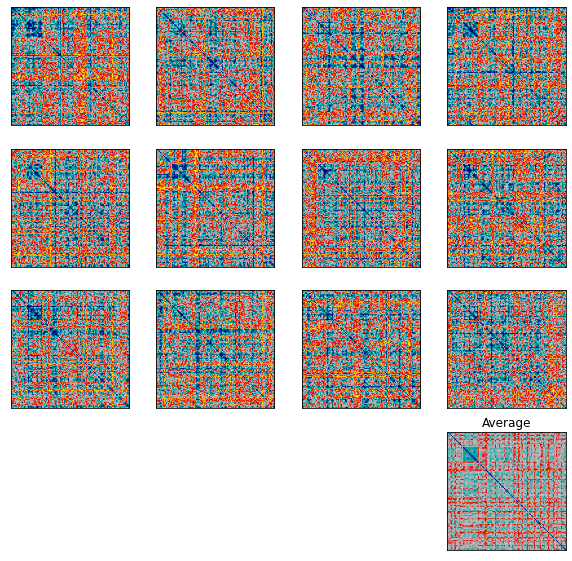

In [7]:
# indices choosing brain-computational model, noise level, and the size of the kernel with which each voxel samples the neural activity
i_rep = 2 #np.random.randint(len(repr_names)) 
i_noise = 1 #np.random.randint(len(noise_std))
i_fwhm = 0 #np.random.randint(len(fwhms))

# print the chosen representation definition
repr_name = repr_names[i_rep]
print('The chosen ground truth model is:')
print(repr_name)
print('with noise level:')
print(noise_std[i_noise])
print('with averaging width (full width at half magnitude):')
print(fwhms[i_fwhm])

# put the rdms into an RDMs object and show it
rdms_data = pyrsa.rdm.RDMs(rdms_matrix[:, i_rep, i_fwhm, i_noise, :].transpose())

plt.figure(figsize=(10,10))
pyrsa.vis.show_rdm(rdms_data, do_rank_transform=True)

### Define fixed models
An "RDM model" is a pyRSA object that can predict a data RDM.
For example, a flexible RDM model may contain a set of predictor RDMs, which predict the data RDM as a weighted combination.
Here we use fixed RDM models, which contain just a single RDM with no parameters to be fitted.

Models are generated by first choosing the RDM, in this case the one with the right "brain_computational_model" and the "measurement_model" "complete", which corresponds to no distortions added. This object is then passed to the function `pyrsa.model.ModelFixed`, which generates a fixed RDM model. These RDM models are then collected in the list `models`. 

In [8]:
models = []
for i_model in np.unique(model_names):
    rdm_m = model_rdms.subset('brain_computational_model', i_model).subset('measurement_model','complete')
    m = pyrsa.model.ModelFixed(i_model, rdm_m)
    models.append(m)

print('created the following models:')
for i in range(len(models)):
    print(models[i].name)

created the following models:
conv1
conv2
conv3
conv4
conv5
fc6
fc7
fc8
prob


### Compare model RDMs to measured RDMs
Evaluate models naively, i.e. simply compute the average correlation to the data RDMs.

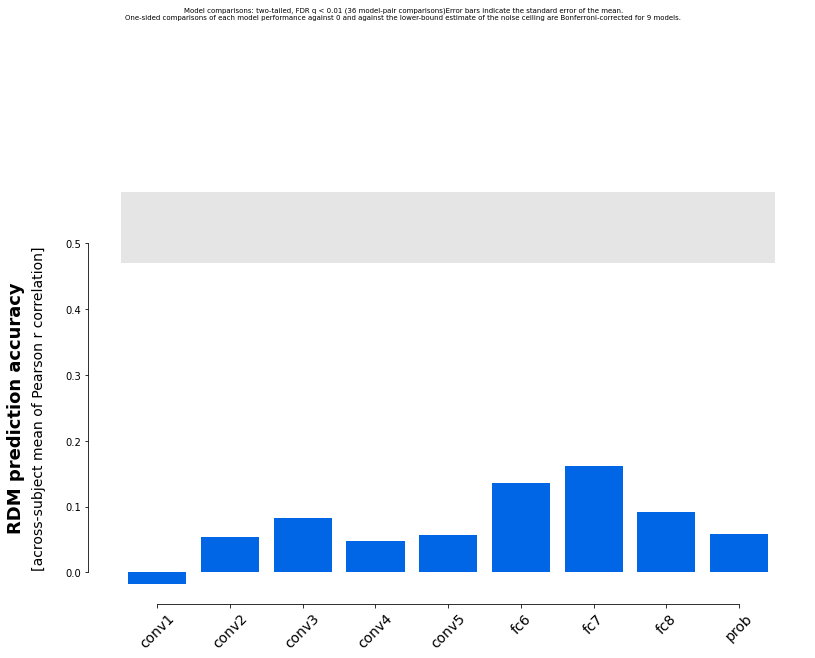

In [9]:
results_1 = pyrsa.inference.eval_fixed(models, rdms_data, method='corr')
pyrsa.vis.plot_model_comparison(results_1)

#results_1 = pyrsa.inference.eval_fixed(models, rdms_data, method='spearman')
#pyrsa.vis.plot_model_comparison(results_1)

#results_1 = pyrsa.inference.eval_fixed(models, rdms_data, method='tau-a')
#pyrsa.vis.plot_model_comparison(results_1)

#results_1 = pyrsa.inference.eval_fixed(models, rdms_data, method='rho-a')
#pyrsa.vis.plot_model_comparison(results_1)

In these plots the models do not have errorbars as we did not run any estimate of the variablitiy.
The upper bound of the noise ceiling is computed by finding the RDM with the highest possible average similarity to the measured RDMs. This is not 1 because the RDMs for different subjects or measurements differ. The lower bound of the noise ceiling is a leave one out crossvalidation of this averaging procedure, i.e. we find the RDM to perform optimally on all but one of the RDMs and evaluate this average RDM on the left-out RDM. Each RDM is left out once and the correlations are averaged.

### Bootstrapping
To perform statistical comparisons and estimate how uncertain we should be about the models' performance, we can perform bootstrapping:

In each plot the errobars correspond to +/- one SEM based on the bootrap samples.
The lines above the plot show which pairwise comparisons are significant.

#### Model comparison by bootstrapping the subjects
We can bootstrap resample the subjects, which estimates how variable the model performances would be if we repeted the experiment with the same stimuli but new subjects from the same population. Based on that uncertainty estimate, we can statistically compare model performances. We would like to take the many pairwise model comparisons into account in performing inference. We have a choice: We can either control the family wise error rate (FWER) or the false discovery rate (FDR). Here we use a Bonferroni correction for FWER and the Benjamini-Hochberg procedure for FDR.

100%|██████████| 1000/1000 [00:19<00:00, 50.22it/s]


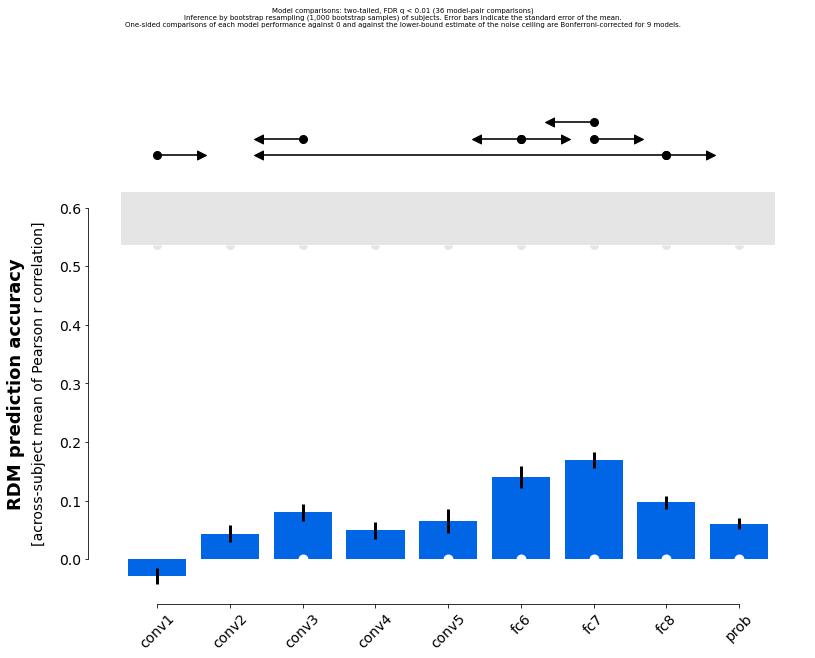

In [10]:
results_2a = pyrsa.inference.eval_bootstrap_rdm(models, rdms_data, method='corr')
pyrsa.vis.plot_model_comparison(results_2a)

#### Model comparison by bootstrapping the stimuli
We can alternatively bootstrap resample the stimuli to estimate how much model performance would vary if we repeated the experiment with the same subjects using a new sample of stimuli from the same population. 

100%|██████████| 1000/1000 [00:34<00:00, 29.18it/s]


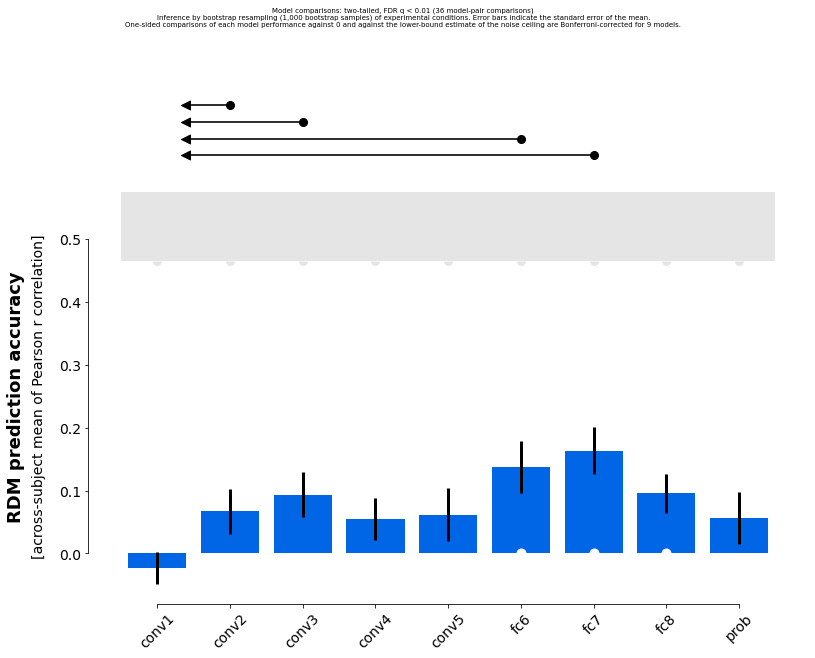

In [11]:
results_2b = pyrsa.inference.eval_bootstrap_pattern(models, rdms_data, method='corr')
pyrsa.vis.plot_model_comparison(results_2b)

#### Model comparison by bootstrapping both stimuli and subjects
Finally, we can bootstrap resample both stimuli and subjects to estimate how variable the model performances would be if we repeated the experiment with new subjects and new stimuli from their respective populations:

100%|██████████| 1000/1000 [00:42<00:00, 23.74it/s]


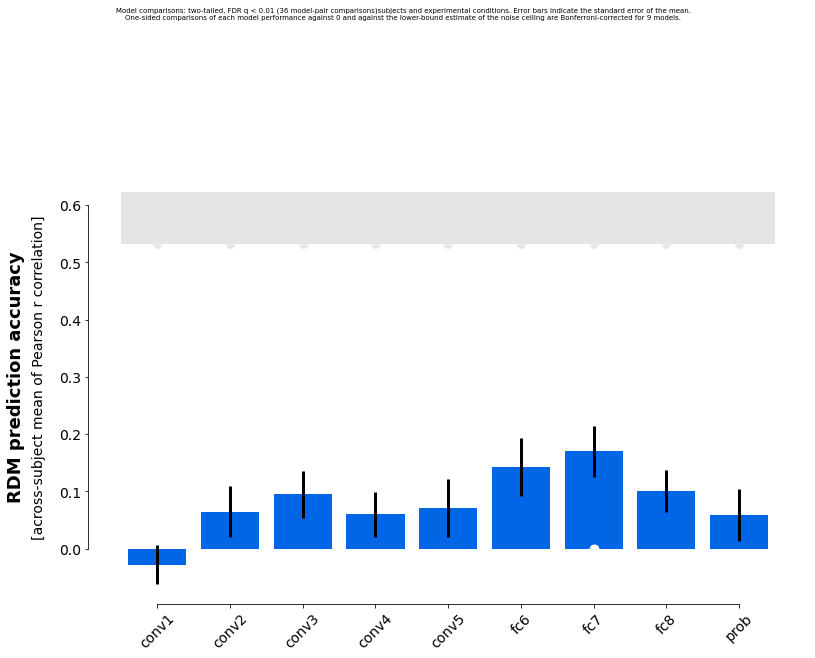

In [12]:
results_2c = pyrsa.inference.eval_bootstrap(models, rdms_data, method='corr')
pyrsa.vis.plot_model_comparison(results_2c)

### Questions
Does the right model win? And do the mean estimates from bootstrapping differ from the evaluations over the whole dataset?

Compare the results for the different bootstrapping methods. Which method leads to the widest confidence intervals, which one to the smallest?

## Exercise 3: Crossvalidation for flexible models
### Defining flexible models
Here we use a type of flexible model called a *selection model*. This type of model specifies that the true RDM is one from a list of RDMs. To evaluate flexible models, they have to be fitted to data, i.e. we need to provide some data, which can be used to adjust the RDM-prediction of the model. For a selection model, the fitting process simply selects the RDM that performs best on the training data. The model will perform better on this data than on independent data. An unbiased performance estimate therefore requires independent test data. Crossvalidation is a data-efficient way of obtaining an unbiased performance estimate.

We first have to generate the selection models. This process is the same as for fixed models, but uses `pyrsa.model.ModelSelect` and passes multiple RDMs instead of a single one:

In [13]:
models_flex = []
for i_model in np.unique(model_names):
    models_flex.append(pyrsa.model.ModelSelect(i_model,
        model_rdms.subset('brain_computational_model', i_model)))

print('created the following models:')
for i in range(len(models_flex)):
    print(models_flex[i].name)

created the following models:
conv1
conv2
conv3
conv4
conv5
fc6
fc7
fc8
prob


### Crossvalidation
As a first step, we split our data into training and test sets, which should not share either subjects or stimuli. To do so, we split each dimension into k groups and leave one of these groups out as a testset and use all others as training data. Models choose their parameters to maximize performance on the training set and are evaluated on the test set. Additionally a so-called *ceil set* is created, which contains the data from the training subjects for the test stimuli, which is necessary for calculating a noise ceiling.

The variables `k_pattern` and `k_rdm` specify how many folds should be formed over stimuli and subjects, respectively.

In [14]:
train_set, test_set, ceil_set = pyrsa.inference.sets_k_fold(rdms_data, k_pattern=3, k_rdm=2)

With these sets we can now evaluate our models, as we did without crossvalidaton, and plot the results. The performance estimates will be averaged across folds and we obtain a single performance estimate without errorbars. The variability over cross-validation folds are not indicative of the variability across independent datasets. Although training and test data are independent of each other in each fold, performance estimates are not independent across folds of crossvalidation.

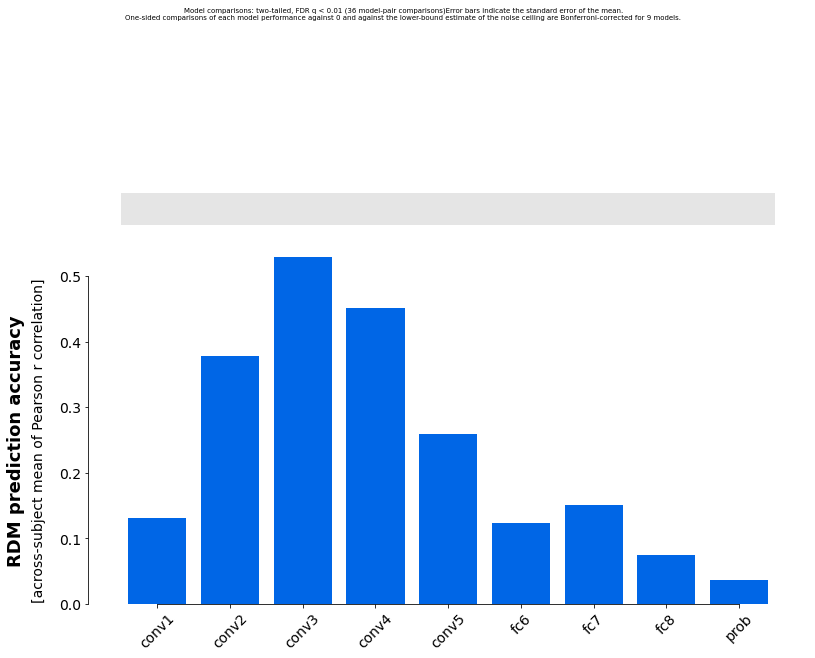

In [15]:
results_3_cv = pyrsa.inference.crossval(models_flex, rdms_data, train_set, test_set,
                                        ceil_set=ceil_set, method='corr')
# plot results
pyrsa.vis.plot_model_comparison(results_3_cv)

### Bootstrapped Crossvalidation

We can perform bootstrapping around the crossvalidation to get uncertainty estimates for the evaluation and for model comparison.

100%|██████████| 100/100 [01:08<00:00,  1.46it/s]


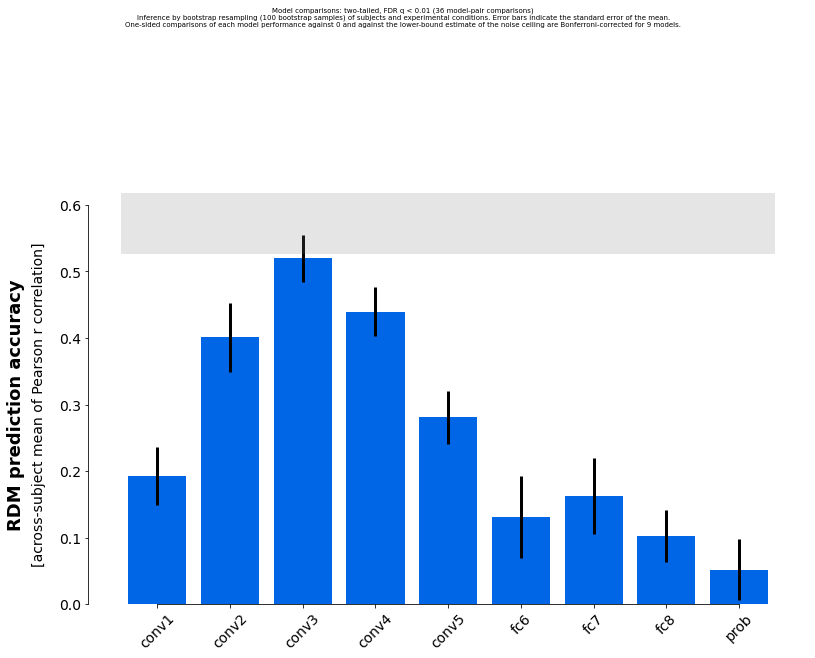

In [16]:
results_3_full = pyrsa.inference.bootstrap_crossval(models_flex, rdms_data, k_pattern=4, k_rdm=2, method='corr', N=100)
# plot results
pyrsa.vis.plot_model_comparison(results_3_full)

### Questions

Does the right model win?

Try some different settings for the crossvalidation: How do the results change when you make the training and test sets larger or smaller?


In [ ]:
#[your code here]